# Training a triplet loss siamese neural network with stochastic quantization model

Importing all required third-party dependencies

In [1]:
import os
import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import sq.optim as sq_optim
import sq.quantization as sq

Choosing a different algorithm for convolutions computations

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

To enforce reproducibility we set the random seed manually

In [3]:
RANDOM_SEED = 1909614334

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"Used random seed: {torch.initial_seed()}")

Used random seed: 1909614334


We set up the computation device for performing optimization

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

We will use MNIST dataset of handwritten digits

In [5]:
EPOCHS = 25

BATCH_TRAIN = 64
BATCH_TEST = 64
DATA_DIR = '../../data/'
RESULTS_DIR = '../../results/'

train_dataset = datasets.MNIST(
    root=DATA_DIR, train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=True)

These are examples of handwritten digits from the dataset

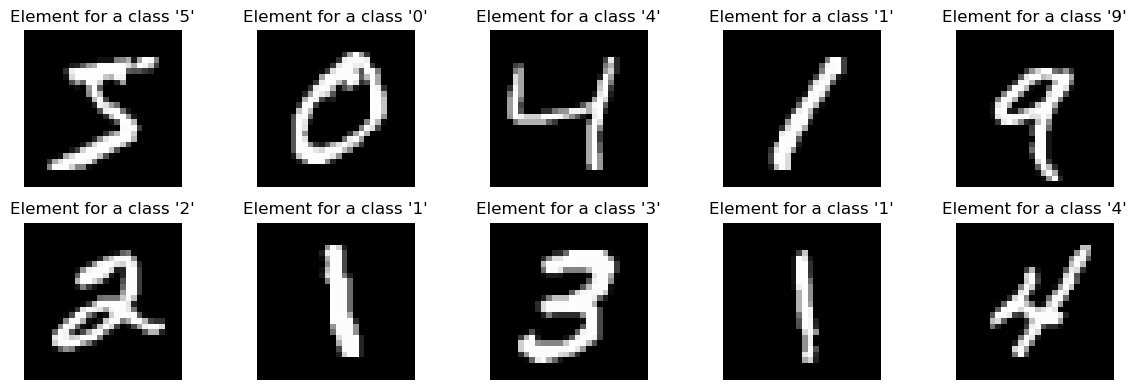

In [6]:
# Selecting random samples for the visual showcase
row_elements = 5

fig, axes = plt.subplots(2, row_elements, figsize=(12, 4))

# Display the samples in the image grid
for i, (image, label) in enumerate(
  itertools.islice(train_dataset, 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].set_title(f"Element for a class '{label}'")
    axes[row, col].axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

A blueprint for a siamese neural network

In [7]:
class SiameseModel(nn.Module):    
    def __init__(self, latent_dim=16):
        super(SiameseModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Flatten(),

            nn.Linear(64 * 7 * 7, 64),
            nn.ELU(),

            nn.Linear(64, latent_dim),
        )

    def forward(self, x):
        return self.encoder(x)

Triplets are mined as semi-hard category in the online mode

In [8]:
def get_triplets(embeddings, labels, margin=1.0):
    pairwise_dist = torch.cdist(embeddings, embeddings)

    # Create a mask for positive pairs (same label)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    positive_mask = labels_equal.to(embeddings.device)

    # Create a mask for negative pairs (different label)
    negative_mask = ~positive_mask

    # Exclude self-comparisons
    mask_no_self = ~torch.eye(embeddings.shape[0], dtype=torch.bool, device=embeddings.device)
    positive_mask = positive_mask & mask_no_self
    negative_mask = negative_mask & mask_no_self

    # Find hardest positive for each anchor
    hardest_positive_dist, _ = (pairwise_dist * positive_mask.float()).max(dim=1)

    # Find semi-hard negatives for each anchor
    semi_hard_negative_mask = (pairwise_dist > hardest_positive_dist.unsqueeze(1)) & \
                              (pairwise_dist < hardest_positive_dist.unsqueeze(1) + margin) & \
                              negative_mask

    # If no semi-hard negative exists, use the hardest negative
    for i in range(embeddings.shape[0]):
        if not semi_hard_negative_mask[i].any():
            hard_negative_dist, hard_negative_idx = (pairwise_dist[i] * negative_mask[i].float()).min(dim=0)
            semi_hard_negative_mask[i, hard_negative_idx] = True

    # Sample triplets
    anchors = []
    positives = []
    negatives = []

    for i in range(embeddings.shape[0]):
        positive_indices = torch.where(positive_mask[i])[0]
        negative_indices = torch.where(semi_hard_negative_mask[i])[0]

        if len(positive_indices) > 0 and len(negative_indices) > 0:
            positive_idx = positive_indices[torch.randint(0, len(positive_indices), (1,))]
            negative_idx = negative_indices[torch.randint(0, len(negative_indices), (1,))]

            anchors.append(embeddings[i])
            positives.append(embeddings[positive_idx].squeeze(0))
            negatives.append(embeddings[negative_idx].squeeze(0))

    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

Building an instance of a siamese neural network and training it on a triplet loss

In [9]:
LATENT_DIM = 3

siamese_model = SiameseModel(latent_dim=LATENT_DIM).to(device)
criterion = nn.TripletMarginLoss(margin=1.0, p=2, reduction='sum')
optimizer = optim.Adam(siamese_model.parameters(), lr=1e-3, weight_decay=1e-05)

train_loss, val_loss = [], []


for epoch in range(EPOCHS):
    epoch_train_loss = []
    epoch_val_loss = []

    # Training loss and accuracy
    siamese_model.train()

    for images, labels in (progress_bar := tqdm(train_dataloader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()

        output = siamese_model(images)
        loss = criterion(*get_triplets(output, labels))

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_train_loss.append(loss.item())
        progress_bar.set_description(f"Train loss: {loss.item():.4f}")

    train_loss.append(np.mean(np.array(epoch_train_loss)))

    # Validation loss and accuracy
    siamese_model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = siamese_model(images)
            loss = criterion(*get_triplets(output, labels))

            epoch_val_loss.append(loss.item())

    val_loss.append(np.mean(np.array(epoch_val_loss)))

    print(f"Validation loss: {loss.item():.4f}")

Train loss: 27.3056: 100%|██████████| 938/938 [00:45<00:00, 20.61it/s]


Validation loss: 16.1917


Train loss: 28.9678: 100%|██████████| 938/938 [00:52<00:00, 17.71it/s]


Validation loss: 14.4774


Train loss: 29.3195: 100%|██████████| 938/938 [00:46<00:00, 20.02it/s]


Validation loss: 14.1446


Train loss: 24.1541: 100%|██████████| 938/938 [00:52<00:00, 17.74it/s]


Validation loss: 14.4901


Train loss: 22.9680: 100%|██████████| 938/938 [00:51<00:00, 18.26it/s]


Validation loss: 13.2964


Train loss: 29.5282: 100%|██████████| 938/938 [00:50<00:00, 18.66it/s]


Validation loss: 13.7386


Train loss: 36.4135: 100%|██████████| 938/938 [00:49<00:00, 19.04it/s]


Validation loss: 16.0421


Train loss: 31.0844: 100%|██████████| 938/938 [00:46<00:00, 20.18it/s]


Validation loss: 19.2841


Train loss: 30.2995: 100%|██████████| 938/938 [00:52<00:00, 17.71it/s]


Validation loss: 16.0152


Train loss: 28.1810: 100%|██████████| 938/938 [00:52<00:00, 17.81it/s]


Validation loss: 17.1949


Train loss: 33.6248: 100%|██████████| 938/938 [00:46<00:00, 20.22it/s]


Validation loss: 14.4527


Train loss: 30.8206: 100%|██████████| 938/938 [00:50<00:00, 18.66it/s]


Validation loss: 13.7046


Train loss: 28.4331: 100%|██████████| 938/938 [00:49<00:00, 18.91it/s]


Validation loss: 15.1367


Train loss: 36.1909: 100%|██████████| 938/938 [00:53<00:00, 17.38it/s]


Validation loss: 18.1828


Train loss: 32.7063: 100%|██████████| 938/938 [00:53<00:00, 17.51it/s]


Validation loss: 16.3195


Train loss: 29.6649: 100%|██████████| 938/938 [00:53<00:00, 17.55it/s]


Validation loss: 17.2714


Train loss: 33.2948: 100%|██████████| 938/938 [00:53<00:00, 17.56it/s]


Validation loss: 15.7250


Train loss: 33.6395: 100%|██████████| 938/938 [00:52<00:00, 17.99it/s]


Validation loss: 13.9672


Train loss: 32.9959: 100%|██████████| 938/938 [00:53<00:00, 17.42it/s]


Validation loss: 16.7331


Train loss: 28.5977: 100%|██████████| 938/938 [00:50<00:00, 18.58it/s]


Validation loss: 9.7573


Train loss: 34.2935: 100%|██████████| 938/938 [00:52<00:00, 17.78it/s]


Validation loss: 15.9488


Train loss: 27.2924: 100%|██████████| 938/938 [00:51<00:00, 18.38it/s]


Validation loss: 16.3498


Train loss: 34.0744: 100%|██████████| 938/938 [00:53<00:00, 17.55it/s]


Validation loss: 8.5420


Train loss: 28.8593: 100%|██████████| 938/938 [00:52<00:00, 17.88it/s]


Validation loss: 15.2285


Train loss: 29.4445: 100%|██████████| 938/938 [00:52<00:00, 17.99it/s]


Validation loss: 13.1706


We compare train and validation losses to detect the overfitting of the model

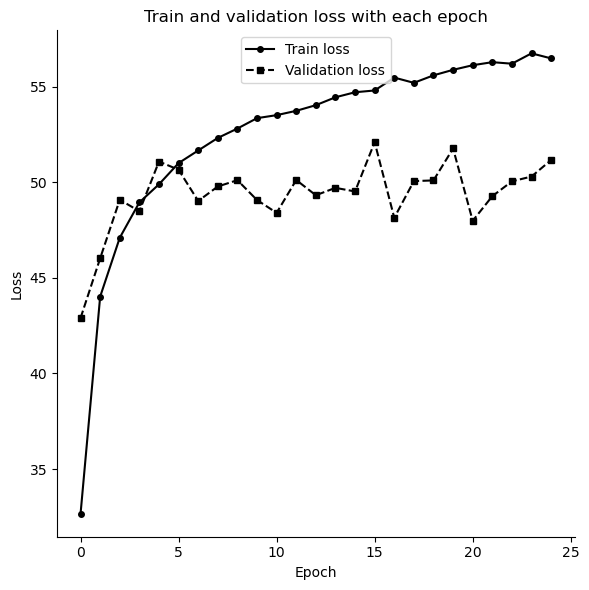

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

ax.plot(range(len(train_loss)), train_loss, linestyle='-',
           marker='o', color='k', markersize=4, label="Train loss")
ax.plot(range(len(val_loss)), val_loss, linestyle='--',
           marker='s', color='k', markersize=4, label="Validation loss")
ax.legend(loc="upper center")
ax.set_title("Train and validation loss with each epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

We convert all handwritten digits from the dataset to visualize their embeddings in the metric space

In [11]:
def group_embeddings_by_label(model: nn.Module, dataloader: DataLoader):
    all_embeddings = np.empty((0, LATENT_DIM))
    grouped_embeddings = {i: np.empty((0, LATENT_DIM)) for i in range(10)}

    for img, lbs in dataloader:
        model_device = next(model.parameters()).device
        batch_embeddings = model(img.to(model_device))
        batch_embeddings = batch_embeddings.cpu().detach().numpy()

        lbs = lbs.detach().numpy()

        for emb, lb in zip(batch_embeddings, lbs):
            grouped_embeddings[lb] = np.vstack((grouped_embeddings[lb], np.array(emb)))

    for cl, embeds in grouped_embeddings.items():
        all_embeddings = np.vstack((all_embeddings, np.array(embeds)))

    return grouped_embeddings, all_embeddings


embedding_model = siamese_model.encoder

with torch.no_grad():
    train_group_embeds, train_all_embeds = group_embeddings_by_label(embedding_model, train_dataloader)
    test_group_embeds, test_all_embeds = group_embeddings_by_label(embedding_model, test_dataloader)

If our latent space has a dimensionality greater than 3, we use PCA to project embeddings on a 3D plane, while trying to preserve an original distribution as much as possible with 90% of variance. As train data embeddings are positioned similarly to the test embeddings, we can assume that encoder learned low-level prepresentations

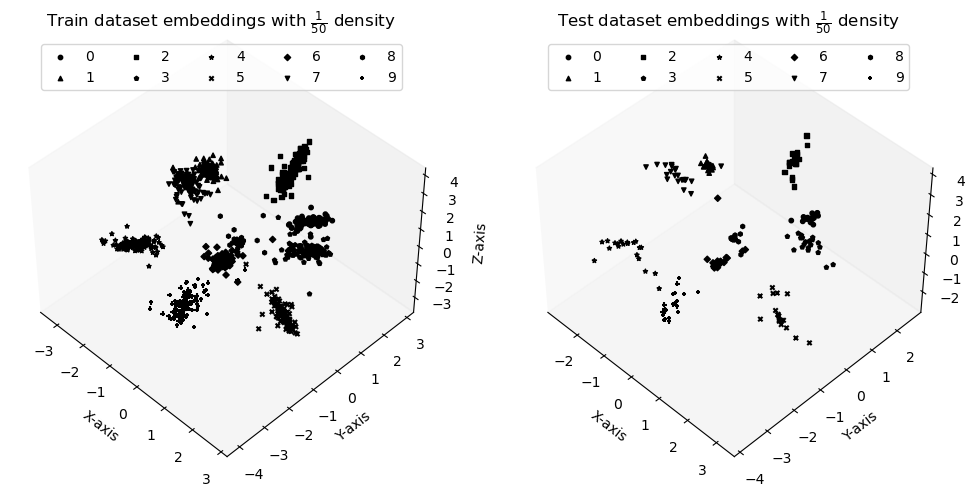

In [12]:
_, embeds_dim = train_all_embeds.shape

if embeds_dim > 3:
    pca = PCA(n_components=3, random_state=RANDOM_SEED).fit(train_all_embeds)

    train_viz_embeds = {cl: pca.transform(embeds) for cl, embeds in train_group_embeds.items()}
    test_viz_embeds = {cl: pca.transform(embeds) for cl, embeds in test_group_embeds.items()}
else:
    train_viz_embeds = train_group_embeds
    test_viz_embeds = test_group_embeds

markers = ['o', '^', 's', 'p', '*', 'x', 'D', 'v', 'h', '+']
markevery, marksize = 50, 10
elev, azim = 45, 315

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(train_viz_embeds.items()):
    subset_embeds = embeds[::markevery]
    ax.scatter3D(subset_embeds[:, 0], subset_embeds[:, 1], subset_embeds[:, 2], color='k',
                 label=cls, alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title(r'Train dataset embeddings with $ \frac{1}{50} $ density')

ax.set_xlabel('X-axis')
# ax.set_xlim((-10.0, 10.0))

ax.set_ylabel('Y-axis')
# ax.set_ylim((-10.0, 10.0))

ax.set_zlabel('Z-axis')
# ax.set_zlim((-10.0, 10.0))

ax.grid(False)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(elev=elev, azim=azim, roll=0)

for idx, (cls, embeds) in enumerate(test_viz_embeds.items()):
    subset_embeds = embeds[::markevery]
    ax.scatter3D(subset_embeds[:, 0], subset_embeds[:, 1], subset_embeds[:, 2], color='k',
                 label=cls, alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax.legend(loc="upper center", ncol=5)
ax.set_title(r'Test dataset embeddings with $ \frac{1}{50} $ density')

ax.set_xlabel('X-axis')
# ax.set_xlim((-10.0, 10.0))

ax.set_ylabel('Y-axis')
# ax.set_ylim((-10.0, 10.0))

ax.set_zlabel('Z-axis')
# ax.set_zlim((-10.0, 10.0))

ax.grid(False)

fig.patch.set_facecolor('white')

plt.show()

We will use stochastic quantization algorithm for the non-convex optimization problem of representations clustering

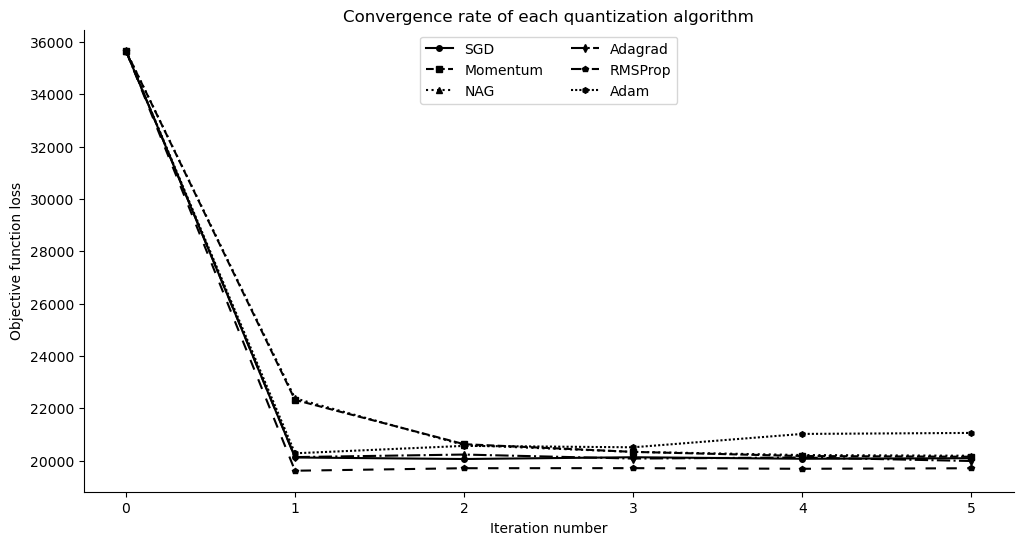

In [13]:
sq_algorithms = {
    "SGD": sq.StochasticQuantization(sq_optim.SGDOptimizer(), n_clusters=10, max_iter=5,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Momentum": sq.StochasticQuantization(sq_optim.MomentumOptimizer(), n_clusters=10, max_iter=5,
                                          learning_rate=0.0001, random_state=np.random.RandomState(RANDOM_SEED)),
    "NAG": sq.StochasticQuantization(sq_optim.NAGOptimizer(), n_clusters=10, max_iter=5,
                                     learning_rate=0.0001, random_state=np.random.RandomState(RANDOM_SEED)),
    "Adagrad": sq.StochasticQuantization(sq_optim.AdagradOptimizer(), n_clusters=10, max_iter=5,
                                         learning_rate=0.5, random_state=np.random.RandomState(RANDOM_SEED)),
    "RMSProp": sq.StochasticQuantization(sq_optim.RMSPropOptimizer(), n_clusters=10, max_iter=5,
                                         random_state=np.random.RandomState(RANDOM_SEED)),
    "Adam": sq.StochasticQuantization(sq_optim.AdamOptimizer(), n_clusters=10, max_iter=5,
                                      learning_rate=0.01, random_state=np.random.RandomState(RANDOM_SEED))
}

markers = [('o', '-'), ('s', '--'), ('^', ':'), ('d', '-.'), ('p', (0, (5, 5))), ('h', (0, (1, 1)))]
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    marker, linestyle = markers[idx % len(markers)]

    alg = alg.fit(train_all_embeds)

    ax.plot(range(len(alg.loss_history_)), alg.loss_history_,
            linestyle=linestyle, marker=marker, color='k',
            markersize=4, label=name)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Convergence rate of each quantization algorithm")
plt.xlabel('Iteration number')
plt.ylabel('Objective function loss')
plt.legend(loc="upper center", ncol=2)
plt.show()

We use confusion matrix to compare the accuracy of classification model for each class

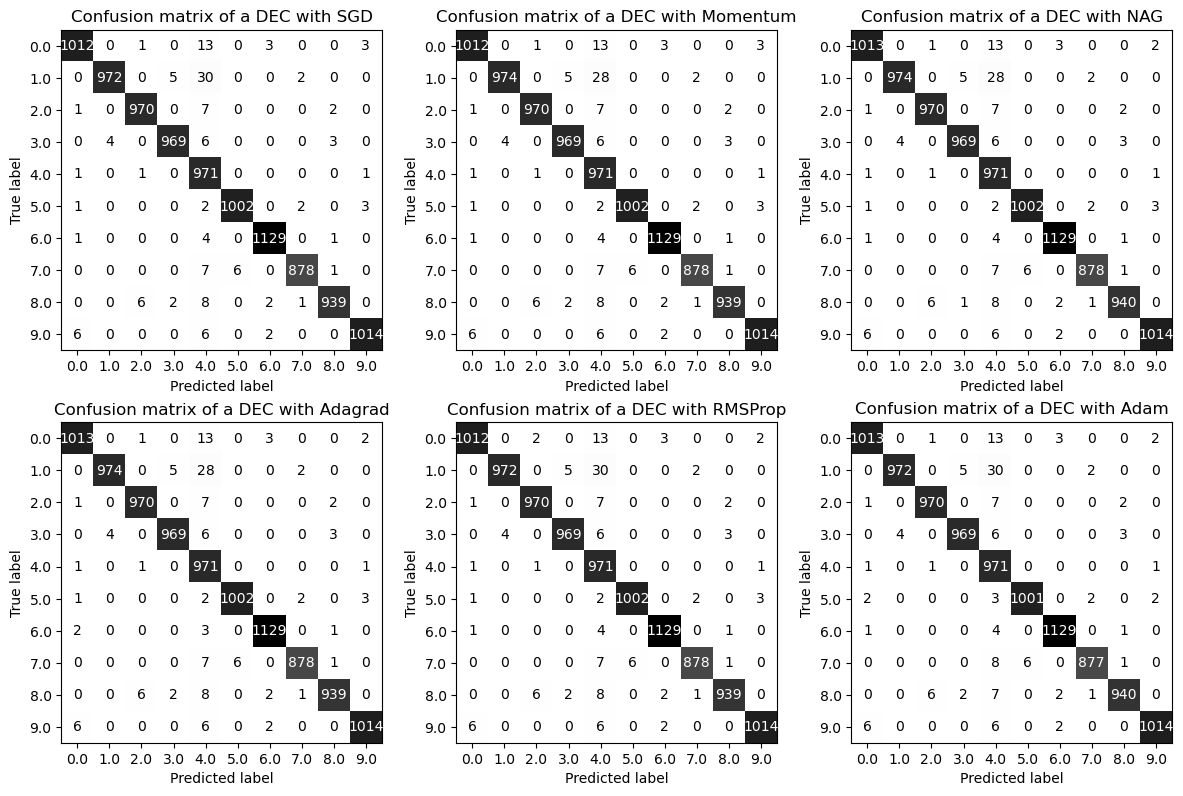

In [14]:
n_col, n_row = (2, 3)
fig, ax = plt.subplots(n_col, n_row, figsize=(12, 8))
f1_scores = {}

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    y_true, y_pred = np.array([]), np.array([])

    for _, embs in test_group_embeds.items():
        cls = alg.predict(embs)
        cls_predicted = np.bincount(cls).argmax()

        y_true = np.append(y_true, np.full((1, len(embs)), cls_predicted))
        y_pred = np.append(y_pred, cls)

    ax_idx = ax[idx // n_row, idx % n_row]

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap="Greys", colorbar=False, ax=ax_idx
    )

    ax_idx.set_title(f"Confusion matrix of a DEC with {name}")
    f1_scores[name] = f1_score(y_true, y_pred, average="weighted")

plt.tight_layout()
plt.show()

To account for label imbalance in the test set, we choose a weighted F1 score as an accuracy metric.

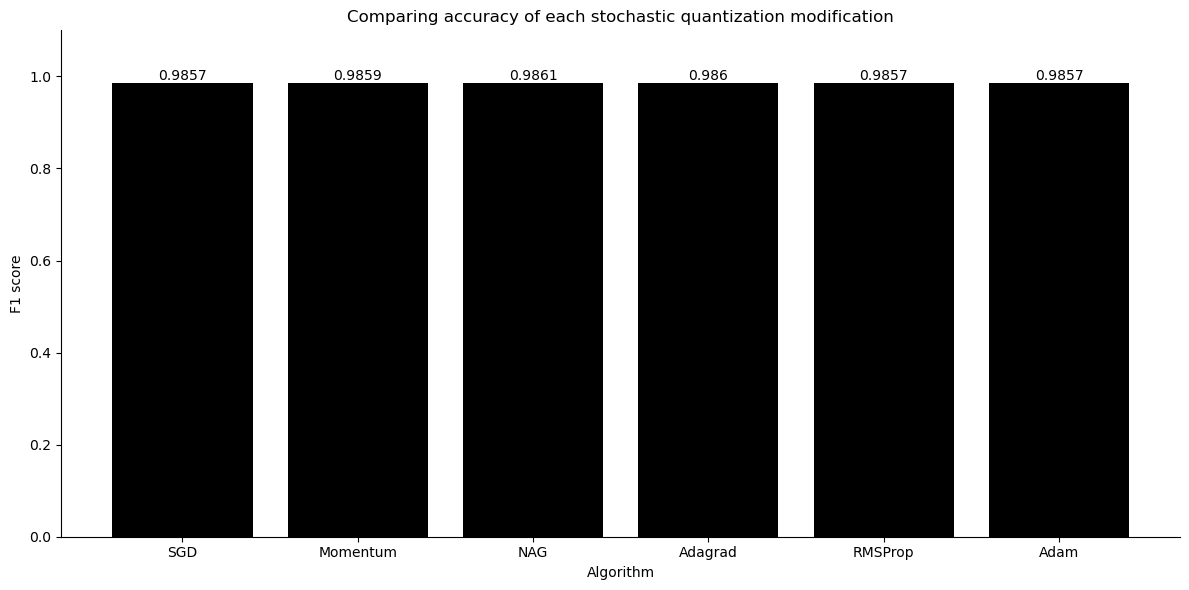

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bars = ax.bar(f1_scores.keys(), f1_scores.values(), color='k')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0,
            height, f'{round(height, 4)}', ha='center', va='bottom')

ax.set_xlabel("Algorithm")
ax.set_ylabel("F1 score")
ax.set_title("Comparing accuracy of each stochastic quantization modification")
ax.set_ylim(top=1.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Save encoder model for the later use

In [16]:
MODEL_DIR = os.path.join(RESULTS_DIR, "model")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

embedding_model.eval()

torch.save(embedding_model.state_dict(), os.path.join(MODEL_DIR, "siamese_model.bin"))